In [1]:
%matplotlib inline
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
# import torch.utils.data
import torch.optim as optim
import torch.backends.cudnn as cudnn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchvision.transforms import ToPILImage
import numpy as np
from PIL import Image
show = ToPILImage()  # 可以把Tensor转成Image，方便可视化

In [2]:
basedir = os.getcwd()
ds_basedir = os.path.abspath("/mnt/traffic/maruokai/datasets")
if not os.path.isdir('results'):
    os.mkdir('results')
out_path = os.path.join(basedir, 'results')

In [3]:
transform_train = transforms.Compose([
    # 在高度和宽度上将图像放大到40像素的正方形
    # transforms.Resize(40),
    # 随机裁剪出一个高度和宽度均为40像素的正方形图像，
    # 生成一个面积为原始图像面积0.64到1倍的小正方形，
    # 然后将其缩放为高度和宽度均为32像素的正方形
    transforms.RandomResizedCrop(32, scale=(0.64, 1.0),
                                 ratio=(1.0, 1.0)),
    transforms.RandomHorizontalFlip(),  # 依照概率p=0.5水平翻转
    transforms.RandomGrayscale(),       # 依照概率p=0.5转化为灰度图
    transforms.ToTensor(),
    transforms.Normalize([0.4914, 0.4822, 0.4465],
                         [0.2023, 0.1994, 0.2010])
    ])

transform_test = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.4914, 0.4822, 0.4465],
                                     [0.2023, 0.1994, 0.2010])])

batch_size = 128
ratio = 0.2

# 读取数据集
dataset = torchvision.datasets.CIFAR10(
    root=ds_basedir, train=True, download=False, transform=transform_train)
test_dataset = torchvision.datasets.CIFAR10(
    root=ds_basedir, train=False, download=False, transform=transform_test)

val_num = int(len(dataset)*ratio)
train_num = int(len(dataset)-val_num)
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_num, val_num])

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)


print(f"Train dataset size = {len(train_dataset)}, batch num = {len(train_loader)}")
print(f"Val dataset size = {len(val_dataset)}, batch num = {len(val_loader)}")
print(f"Test dataset size = {len(test_dataset)}, batch num = {len(test_loader)}")

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

Train dataset size = 40000, batch num = 313
Val dataset size = 10000, batch num = 79
Test dataset size = 10000, batch num = 79


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


128 128
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)


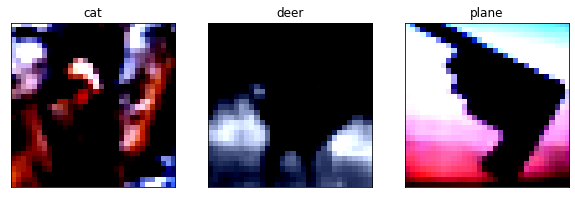

In [4]:
# 显示图片
def display(display_num=3, scale=10):
    cnt = 0
    fig,axes = plt.subplots(1, display_num, figsize=(1*scale, display_num*scale))
    axes = axes.flatten()
    images, labels = next(iter(train_loader))
    print(len(images), len(labels))
    for i, (image, label) in enumerate(zip(images, labels)):
        if cnt >= display_num:
            break
        #print(image.shape)
        image = image.numpy() # FloatTensor转为ndarray
        image = np.transpose(image, (1,2,0)) # 把channel放到最后，(h, w, channel)
        print(image.shape)
        ax = axes[cnt]
        ax.imshow(image)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        ax.set_title(classes[label])
        cnt += 1
    fig.show()
display()

In [5]:
'''ResNet in PyTorch.
'''
import torch
import torch.nn as nn
import torch.nn.functional as F


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])


def ResNet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])


def ResNet50():
    return ResNet(Bottleneck, [3, 4, 6, 3])


def ResNet101():
    return ResNet(Bottleneck, [3, 4, 23, 3])


def ResNet152():
    return ResNet(Bottleneck, [3, 8, 36, 3])


def test():
    net = ResNet18()
    y = net(torch.randn(1, 3, 32, 32))
    print(y.size())

In [6]:
def train(num_epoch, criterion, optimizer):
    global train_loss_history, val_loss_history
    global train_acc_history, val_acc_history
    global best_acc
    model.train()
    for epoch in range(num_epoch):
        train_loss = 0
        correct = 0
        total = 0
        for inputs, labels in tqdm(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            # grad_norm = nn.utils.clip_grad_norm_(model.parameters(), max_norm=10)
            optimizer.step()
            train_loss+=loss.item()
            correct+=(outputs.argmax(dim=-1) == labels).sum().item()
            total +=outputs.size(0)
        loss = 1.*train_loss/len(train_loader)
        acc = 1.*correct/total
        train_loss_history.append(loss)
        train_acc_history.append(acc)
        if (epoch%10==9):
            print(f"[ Train | {epoch + 1:03d}/{num_epoch:03d} ] loss = {loss:.5f}, acc = {acc:.5f}")
        
        model.eval()
        val_loss = 0
        correct = 0
        total = 0
        for inputs, labels in tqdm(val_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            with torch.no_grad():
                outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss+=loss.item()
            correct+=(outputs.argmax(dim=-1) == labels).sum().item()
            total +=outputs.size(0)
        loss = 1.*val_loss/len(val_loader)
        acc = 1.*correct/total
        val_loss_history.append(loss)
        val_acc_history.append(acc)
        if (epoch%10==9):
            print(f"[ Valid | {epoch + 1:03d}/{num_epoch:03d} ] loss = {loss:.5f}, acc = {acc:.5f}")
        
        if acc>best_acc:
            best_acc = acc
            state = {
                'model': model.state_dict(),
                'acc': acc,
                'epoch': epoch,
            }
            if not os.path.isdir('checkpoint'):
                os.mkdir('checkpoint')
            torch.save(state, './checkpoint/ckpt.pth')


In [7]:
def test():
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    for inputs, labels in tqdm(test_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        with torch.no_grad():
            outputs = model(inputs)
        loss = criterion(outputs, labels)
            
        test_loss+=loss.item()
        correct+=(outputs.argmax(dim=-1) == labels).sum().item()
        total +=outputs.size(0)
    loss = 1.*test_loss/len(test_loader)
    acc = 1.*correct/total

    print(f"loss = {loss:.5f}, acc = {acc:.5f}")


In [8]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
print(os.environ['CUDA_VISIBLE_DEVICES'])
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

model = ResNet34()
model = model.to(device)
num_epoch = 150
lr = 0.0001
best_acc = 0
best_epoch = 0
train_loss_history = []
val_loss_history = []
train_acc_history = []
val_acc_history = []

if os.path.isdir('checkpoint'):
    checkpoint = torch.load('./checkpoint/ckpt.pth')
    model.load_state_dict(checkpoint['model'], False)
    best_acc = checkpoint['acc']
    best_epoch = checkpoint['epoch']

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=5e-5)
if device=='cuda':
    model = torch.nn.DataParallel(model)
    cudnn.benchmark = True
train(num_epoch, criterion, optimizer)
test()

0
cuda


100%|██████████| 313/313 [00:26<00:00, 12.01it/s]


[ Train | 010/150 ] loss = 1.14601, acc = 0.58927


100%|██████████| 79/79 [00:02<00:00, 29.50it/s]


[ Valid | 010/150 ] loss = 1.19186, acc = 0.57420


100%|██████████| 313/313 [00:26<00:00, 11.72it/s]


[ Train | 020/150 ] loss = 0.84979, acc = 0.69663


100%|██████████| 79/79 [00:02<00:00, 28.01it/s]


[ Valid | 020/150 ] loss = 0.89367, acc = 0.68240


100%|██████████| 313/313 [00:25<00:00, 12.26it/s]


[ Train | 030/150 ] loss = 0.67422, acc = 0.76515


100%|██████████| 79/79 [00:02<00:00, 30.43it/s]


[ Valid | 030/150 ] loss = 0.77265, acc = 0.73160


100%|██████████| 313/313 [00:25<00:00, 12.07it/s]


[ Train | 040/150 ] loss = 0.55573, acc = 0.80483


100%|██████████| 79/79 [00:02<00:00, 28.70it/s]


[ Valid | 040/150 ] loss = 0.67643, acc = 0.76280


100%|██████████| 313/313 [00:25<00:00, 12.30it/s]


[ Train | 050/150 ] loss = 0.45863, acc = 0.84015


100%|██████████| 79/79 [00:03<00:00, 22.73it/s]


[ Valid | 050/150 ] loss = 0.63680, acc = 0.78190


100%|██████████| 313/313 [00:24<00:00, 12.95it/s]


[ Train | 060/150 ] loss = 0.38847, acc = 0.86275


100%|██████████| 79/79 [00:02<00:00, 28.37it/s]


[ Valid | 060/150 ] loss = 0.61797, acc = 0.79570


100%|██████████| 313/313 [00:24<00:00, 12.66it/s]


[ Train | 070/150 ] loss = 0.32883, acc = 0.88518


100%|██████████| 79/79 [00:01<00:00, 40.93it/s]


[ Valid | 070/150 ] loss = 0.64065, acc = 0.79250


100%|██████████| 313/313 [00:16<00:00, 19.01it/s]


[ Train | 080/150 ] loss = 0.28463, acc = 0.90045


100%|██████████| 79/79 [00:01<00:00, 39.96it/s]


[ Valid | 080/150 ] loss = 0.64318, acc = 0.80150


100%|██████████| 313/313 [00:22<00:00, 14.03it/s]


[ Train | 090/150 ] loss = 0.23236, acc = 0.92048


100%|██████████| 79/79 [00:02<00:00, 34.51it/s]


[ Valid | 090/150 ] loss = 0.68366, acc = 0.79960


100%|██████████| 313/313 [00:23<00:00, 13.04it/s]


[ Train | 100/150 ] loss = 0.19719, acc = 0.93180


100%|██████████| 79/79 [00:02<00:00, 30.55it/s]


[ Valid | 100/150 ] loss = 0.72924, acc = 0.79750


100%|██████████| 313/313 [00:23<00:00, 13.44it/s]


[ Train | 110/150 ] loss = 0.16800, acc = 0.94283


100%|██████████| 79/79 [00:02<00:00, 31.55it/s]


[ Valid | 110/150 ] loss = 0.70398, acc = 0.80930


100%|██████████| 313/313 [00:22<00:00, 13.76it/s]


[ Train | 120/150 ] loss = 0.15474, acc = 0.94830


100%|██████████| 79/79 [00:02<00:00, 30.52it/s]


[ Valid | 120/150 ] loss = 0.74163, acc = 0.81050


100%|██████████| 313/313 [00:21<00:00, 14.26it/s]


[ Train | 130/150 ] loss = 0.13025, acc = 0.95625


100%|██████████| 79/79 [00:02<00:00, 32.54it/s]


[ Valid | 130/150 ] loss = 0.64763, acc = 0.83070


100%|██████████| 313/313 [00:23<00:00, 13.52it/s]


[ Train | 140/150 ] loss = 0.11458, acc = 0.96137


100%|██████████| 79/79 [00:02<00:00, 30.63it/s]


[ Valid | 140/150 ] loss = 0.67706, acc = 0.82980


100%|██████████| 313/313 [00:23<00:00, 13.30it/s]


[ Train | 150/150 ] loss = 0.09614, acc = 0.96837


100%|██████████| 79/79 [00:02<00:00, 31.41it/s]


[ Valid | 150/150 ] loss = 0.73305, acc = 0.81830


100%|██████████| 79/79 [00:02<00:00, 33.53it/s]

loss = 0.71296, acc = 0.83050


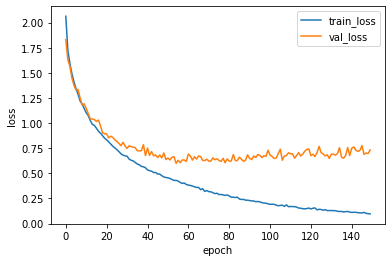

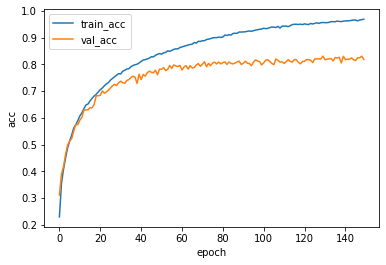

In [60]:
plt.figure()
plt.plot(range(len(train_loss_history)), train_loss_history, label='train_loss')
plt.plot(range(len(val_loss_history)), val_loss_history, label='val_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.savefig(os.path.join(out_path, 'loss.png'))

plt.figure()
plt.plot(range(len(train_acc_history)), train_acc_history, label='train_acc')
plt.plot(range(len(val_acc_history)), val_acc_history, label='val_acc')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend()
plt.savefig(os.path.join(out_path, 'acc.png'))

np.save(os.path.join(out_path, 'train_loss_history.npy'), train_loss_history)
np.save(os.path.join(out_path, 'train_acc_history.npy'), train_acc_history)
np.save(os.path.join(out_path, 'val_loss_history.npy'), val_loss_history)
np.save(os.path.join(out_path, 'val_acc_history.npy'), val_acc_history)

In [84]:
# JUST FOR TEST
# print(model.state_dict())
# print(len(model.state_dict()))  #218
# for name, _ in model.state_dict().items():
#     print(name, _)

# for name, value in model.named_parameters():
#     print (value)
# for id, parameter in enumerate(model.named_parameters()):   #110,剩余108个尽在state_dict中出现
#     print(id, parameter)
if os.path.isdir('checkpoint'):
    checkpoint = torch.load('./checkpoint/ckpt.pth')
    print(checkpoint)
    model.load_state_dict(checkpoint['model'])
    best_acc = checkpoint['acc']
    best_epoch = checkpoint['epoch']

OrderedDict([('module.conv1.weight', tensor([[[[-1.3395e-01, -5.8035e-02, -1.4735e-01],
          [-1.8017e-01, -2.2948e-02, -1.9068e-01],
          [-6.6878e-02,  1.4126e-01,  1.7927e-01]],

         [[ 3.6284e-02,  1.8675e-01,  1.7888e-01],
          [ 1.0210e-01,  5.0599e-02,  3.7915e-02],
          [-3.2614e-02,  1.2445e-01,  1.4439e-02]],

         [[-1.8241e-01,  2.8090e-02,  5.1898e-02],
          [ 1.3099e-01, -7.1538e-03,  1.3222e-01],
          [-1.9492e-01, -1.8564e-01, -1.1087e-01]]],


        [[[ 1.9480e-02,  1.8573e-02,  1.2204e-01],
          [ 1.6065e-03,  1.1003e-01, -1.7759e-01],
          [ 6.0793e-02,  9.0384e-02,  8.4043e-04]],

         [[-7.1718e-03, -2.2506e-01, -1.3076e-01],
          [ 1.6276e-01, -1.7515e-01,  9.8887e-02],
          [-1.8295e-01,  1.4067e-01, -3.8295e-02]],

         [[ 1.3180e-01,  9.3424e-02, -8.5202e-02],
          [-1.6096e-01, -2.3878e-03,  1.8985e-01],
          [-1.4798e-01,  4.7907e-02,  8.5490e-02]]],


        [[[ 1.8474e-02,  3.68

In [85]:
test()

100%|██████████| 79/79 [00:02<00:00, 35.42it/s]

loss = 0.65146, acc = 0.83500
